# Preliminary Data Analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(corrplot)
library(Hmisc)
library(gridExtra)
options(repr.matrix.max.rows = 15)
options(repr.plot.width = 10, repr.plot.height = 8)
set.seed(1234)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
diabetes <- read_csv("https://raw.githubusercontent.com/florencesanjaya/DSCI-100-2023w1-group-36/main/diabetes_prediction_dataset.csv")

Rows: 100000 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, smoking_history
dbl (7): age, hypertension, heart_disease, bmi, HbA1c_level, blood_glucose_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## 1. Data Descriptions

### 1.1 Basic Structure of Data

In [3]:
glimpse(diabetes)

Rows: 100,000
Columns: 9
$ gender              <chr> "Female", "Female", "Male", "Female", "Male", "Fem…
$ age                 <dbl> 80, 54, 28, 36, 76, 20, 44, 79, 42, 32, 53, 54, 78…
$ hypertension        <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ heart_disease       <dbl> 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ smoking_history     <chr> "never", "No Info", "never", "current", "current",…
$ bmi                 <dbl> 25.19, 27.32, 27.32, 23.45, 20.14, 27.32, 19.31, 2…
$ HbA1c_level         <dbl> 6.6, 6.6, 5.7, 5.0, 4.8, 6.6, 6.5, 5.7, 4.8, 5.0, …
$ blood_glucose_level <dbl> 140, 80, 158, 155, 155, 85, 200, 85, 145, 100, 85,…
$ diabetes            <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


### 1.2 Descriptions
This dataset is a collection of medical and demographic data from patients, along with their diabetes status (positive or negative). The dataset contains 100000 observations and 9 variables.     
#### **Response** variable:
Diabetes: the diagnosis of diabetes (1 = true, 0 = false)     
#### **Predictor** variables:     
1. Gender: the gender of the patient ("Female", "Male", "Other")
2. Age: the age of the patient
3. Hypertension: indicator of whether the patient has a hypertension, a medical condition in which the blood pressure in the arteries is persistently elevated (1 = true, 0 = false)
4. Heart Disease: indicator of whether the patient has a heart_disease (1 = true, 0 = false)
5. Smoking History: the smoking history of the patient ("Never", "Current", "Former", "Ever", "Not Current", "No Info")
6. BMI (Body Mass Index): a person's weight in kilograms (or pounds) divided by the square of height in meters (or feet). A high BMI can indicate high body fatness
7. HbA1c Level: the average blood glucose (sugar) levels for the last two or three months
8. Blood Glucose Level: the amuont of glucose (sugar) in the bloodstream at a given time

## 2. Cleaning and Wrangling Data

### 2.1 Checking duplicates in the dataset

In [4]:
print(paste0("Duplicated rows: ", sum(duplicated(diabetes))))

[1] "Duplicated rows: 3854"


Here we find that there are 3854 duplicated observations. Since R `duplicated` function determines which rows of a data frame are exactly the same, we just remove those duplicated rows from our dataset.

In [5]:
diabetes <- distinct(diabetes)
print(paste0("Number of observations: ",nrow(diabetes)))
print(paste0("Duplicated rows: ", sum(duplicated(diabetes))))

[1] "Number of observations: 96146"
[1] "Duplicated rows: 0"


### 2.2 Checking imalance of data

In [6]:
diabetes <- diabetes |>
mutate(hypertension = case_when(hypertension == 1 ~ "True", hypertension == 0 ~ "False"), 
       heart_disease = case_when(heart_disease == 1 ~ "True", heart_disease == 0 ~ "False"),
       diabetes = case_when(diabetes == 1 ~ "True", diabetes == 0 ~ "False")) |>
mutate(hypertension = as_factor(hypertension),
      heart_disease = as_factor(heart_disease),
      diabetes = as_factor(diabetes))

#### 2.2.1 Checking class imbalance of response variable

In [7]:
diabetes |>
group_by(diabetes) |>
summarise(count = n()) |>
mutate(percentage = paste0(round(100*count/sum(count),digit = 2), "%"))

diabetes count percentage
1 False    87664 91.18%    
2 True      8482 8.82%

We noticed that there was indeed a significant imbalance in our diabetes classes. This may cause bad performance of our classification models without properly selecting training data and testing data. However, based on the fact that the prevalence of diabetes in people is relatively low (only about [10%](https://idf.org/about-diabetes/diabetes-facts-figures/) of adults have diabetes), we think the imbalance here is reasonable and will keep this imbalance in our future study.

#### 2.2.2 Checking class imbalance of categorical predictor variables

#### Gender

In [8]:
diabetes |>
group_by(gender) |>
summarise(count = n()) |>
mutate(percentage = paste0(round(100*count/sum(count),digit = 2), "%"))

gender count percentage
1 Female 56161 58.41%    
2 Male   39967 41.57%    
3 Other     18 0.02%

Based on the table above, there are only 18 patients of "Other" gender class, which is too small among our nearly 100000 observation. So we decide to ignore these rare data and focus on two main gender types: male and female.

In [9]:
diabetes <- diabetes |>
filter(gender != "Other")

In [10]:
diabetes |>
group_by(gender) |>
summarise(count = n()) |>
mutate(percentage = paste0(round(100*count/sum(count),digit = 2), "%"))

gender count percentage
1 Female 56161 58.42%    
2 Male   39967 41.58%

#### Hypertension and Heart Disease

In [11]:
hyper_count <- diabetes |>
group_by(hypertension) |>
summarise(count = n()) |>
pivot_wider(names_from = hypertension, values_from = count)


heart_count <- diabetes |>
group_by(heart_disease) |>
summarise(count = n()) |>
pivot_wider(names_from = heart_disease, values_from = count)

combined_count <- rbind(hyper_count, heart_count)
feature = c("Hypertension", "Heart Disease")
combined_count <- cbind(feature, combined_count) |>
pivot_longer(cols = False:True, names_to = "value", values_to = "count") |>
group_by(feature) |>
mutate(percentage = paste0(round(100*count/sum(count), digit=2), "%"))

combined_count


feature       value count percentage
1 Hypertension  False 88667 92.24%    
2 Hypertension  True   7461 7.76%     
3 Heart Disease False 92205 95.92%    
4 Heart Disease True   3923 4.08%

There are also imbalances in hypertension and heart disease, whose patterns are similar to that of diabetes. This may indicate these variables are strongly related to diabetes.

#### Smoking History

In [12]:
diabetes |>
group_by(smoking_history) |>
summarise(count = n()) |>
mutate(percentage = paste0(round(100*count/sum(count),digit = 2), "%"))

smoking_history count percentage
1 No Info         32881 34.21%    
2 current          9197 9.57%     
3 ever             3997 4.16%     
4 former           9299 9.67%     
5 never           34395 35.78%    
6 not current      6359 6.62%

### 2.3 Checking Missing Data

In [13]:
sum(is.na(diabetes))

[1] 0

There is no missing data indicated by R in this dataset. However, we discovered that there is a value "No Info" in Smoking History, which implies that we are missing the data of smoking history for these observations.

In [14]:
diabetes_no_smoking_history <- diabetes |>
filter(smoking_history == "No Info")
nrow(diabetes_no_smoking_history)

[1] 32881

There are 35816 observations with missing smoking history data, possible guesses could be related to age and gender. So we analyzed the distribution of age and gender among those patients.

gender count percentage
1 Female 17969 54.65%    
2 Male   14912 45.35%

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


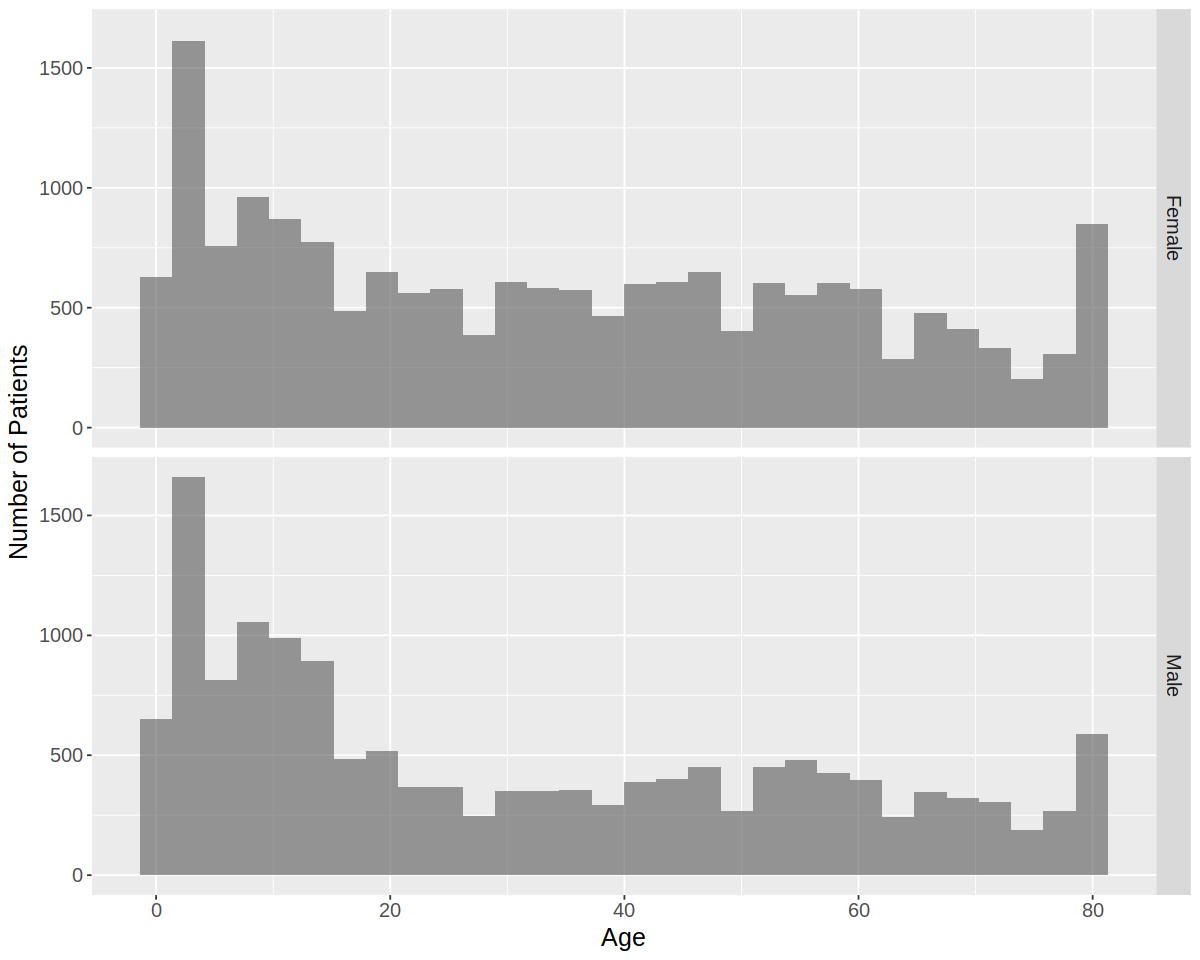

In [15]:
diabetes_no_smoking_history |>
group_by(gender) |>
summarise(count = n()) |>
mutate(percentage = paste0(round(100*count/sum(count),digit = 2), "%"))


ggplot(diabetes_no_smoking_history, aes(x = age)) +
geom_histogram(alpha = 0.6) +
facet_grid(rows = vars(gender)) +
labs(x = "Age", y = "Number of Patients") +
theme(text = element_text(size = 15))

According to the table and the plot above, there is no significant difference between the number of male and female patients with no information for smoking history. And the distribution of age shows a approximately uniform distribution among all age levels. So we categorize these missing data to be missing completely by random.

### 2.4 Checking potential outliers

#### Age

In [16]:
summary(diabetes$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.08   24.00   43.00   41.80   59.00   80.00 

In [17]:
abnormal_age <- diabetes|>
filter(age < 1)
summary(abnormal_age$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0800  0.3200  0.5600  0.5275  0.7200  0.8800 

In [18]:
diabetes |>
filter(age <= 5) |>
group_by(diabetes) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"))

diabetes count percentage
1 False    6123  99.87%    
2 True        8  0.13%

First, we noticed that there were some age data in our dataset which are below age 1. This seems not normal since patients with these ages are just infants and toddlers.

Second, according to [previous studies](https://www.pregnancybirthbaby.org.au/diabetes-in-young-children#:~:text=Diabetes%20is%20rare%20in%20children,diabetes%20and%20manage%20the%20condition.) about the age range of patients with diabetes, diabetes is too rare among children under age 5. And as shown in the table above, the proportion of having diabetes under age 5 is only 0.13%. 

Therefore, we decided to just focus our analysis on the patients above age 5.

In [19]:
diabetes <- diabetes |>
filter(age > 5)

## 3. Explorary Data Analysis

## 3.1 Setting up training and testing datasets

In [20]:
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = diabetes)
diabetes_training <- training(diabetes_split)
diabetes_testing <- testing(diabetes_split)
glimpse(diabetes_training)

Rows: 67,497
Columns: 9
$ gender              <chr> "Female", "Female", "Male", "Female", "Female", "F…
$ age                 <dbl> 80, 54, 28, 20, 44, 32, 53, 67, 78, 15, 42, 42, 40…
$ hypertension        <fct> False, False, False, False, False, False, False, F…
$ heart_disease       <fct> True, False, False, False, False, False, False, Fa…
$ smoking_history     <chr> "never", "No Info", "never", "never", "never", "ne…
$ bmi                 <dbl> 25.19, 27.32, 27.32, 27.32, 19.31, 27.32, 27.32, 2…
$ HbA1c_level         <dbl> 6.6, 6.6, 5.7, 6.6, 6.5, 5.0, 6.1, 5.8, 6.6, 6.1, …
$ blood_glucose_level <dbl> 140, 80, 158, 85, 200, 100, 85, 200, 126, 200, 158…
$ diabetes            <fct> False, False, False, False, True, False, False, Fa…


The proportion of the positive class (patients with diabetes) is almost the same as the original dataset, so it is reasonable to use this subset of data as training dataset.

## 3.2 Univariate & Multivariate Analysis

In [21]:
diabetes_numeric <- diabetes_training |>
select(-c(diabetes, gender, heart_disease, hypertension, smoking_history))

### Age

In [22]:
diabetes_age <- diabetes_training |>
mutate(age_range = case_when(age > 5 & age < 20 ~ "5 ~ 20",
                            age >= 20 & age < 35 ~ "20 ~ 34",
                            age >= 35 & age < 45 ~ "35 ~ 44",
                            age >= 45 & age < 55 ~ "45 ~ 54",
                            age >= 55 & age < 75 ~ "55 ~ 74",
                            age >= 75 ~ "75 ~ 80")) |>
mutate(age_range = factor(age_range,
                         levels = c("5 ~ 20","20 ~ 34","35 ~ 44","45 ~ 54","55 ~ 74","75 ~ 80")))

We first take a look at the distribution of age among patients with diabetes and without diabetes

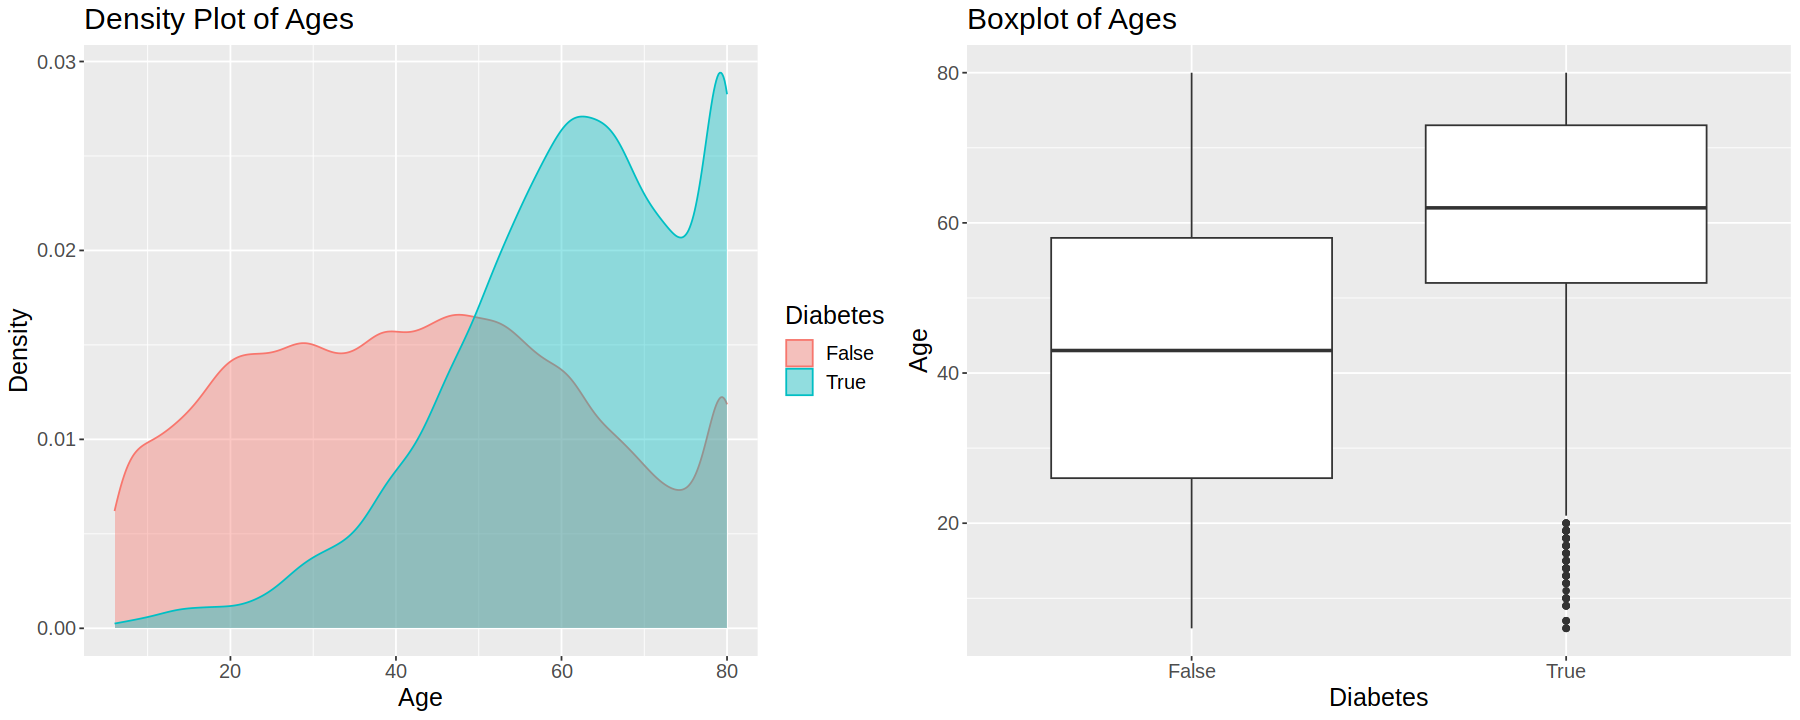

In [23]:
options(repr.plot.width = 15, repr.plot.height = 6)
age_density <- diabetes_training |>
ggplot(aes(x = age, color = diabetes, fill = diabetes)) +
geom_density(alpha = 0.4) +
ggtitle("Density Plot of Ages") +
labs(x = "Age", y = "Density", color = "Diabetes", fill = "Diabetes") +
theme(text = element_text(size = 15))

age_boxplot <- diabetes_training |>
ggplot(aes(x = diabetes, y = age)) +
geom_boxplot() +
ggtitle("Boxplot of Ages") +
labs(x = "Diabetes", y = "Age") +
theme(text = element_text(size = 15))

grid.arrange(age_density, age_boxplot, ncol = 2)

As shown in the plots above, there is a significant difference between the age range of patients with diabetes and without diabetes. And there seems to be a tendency that older people are prone to have diabetes.

### BMI

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


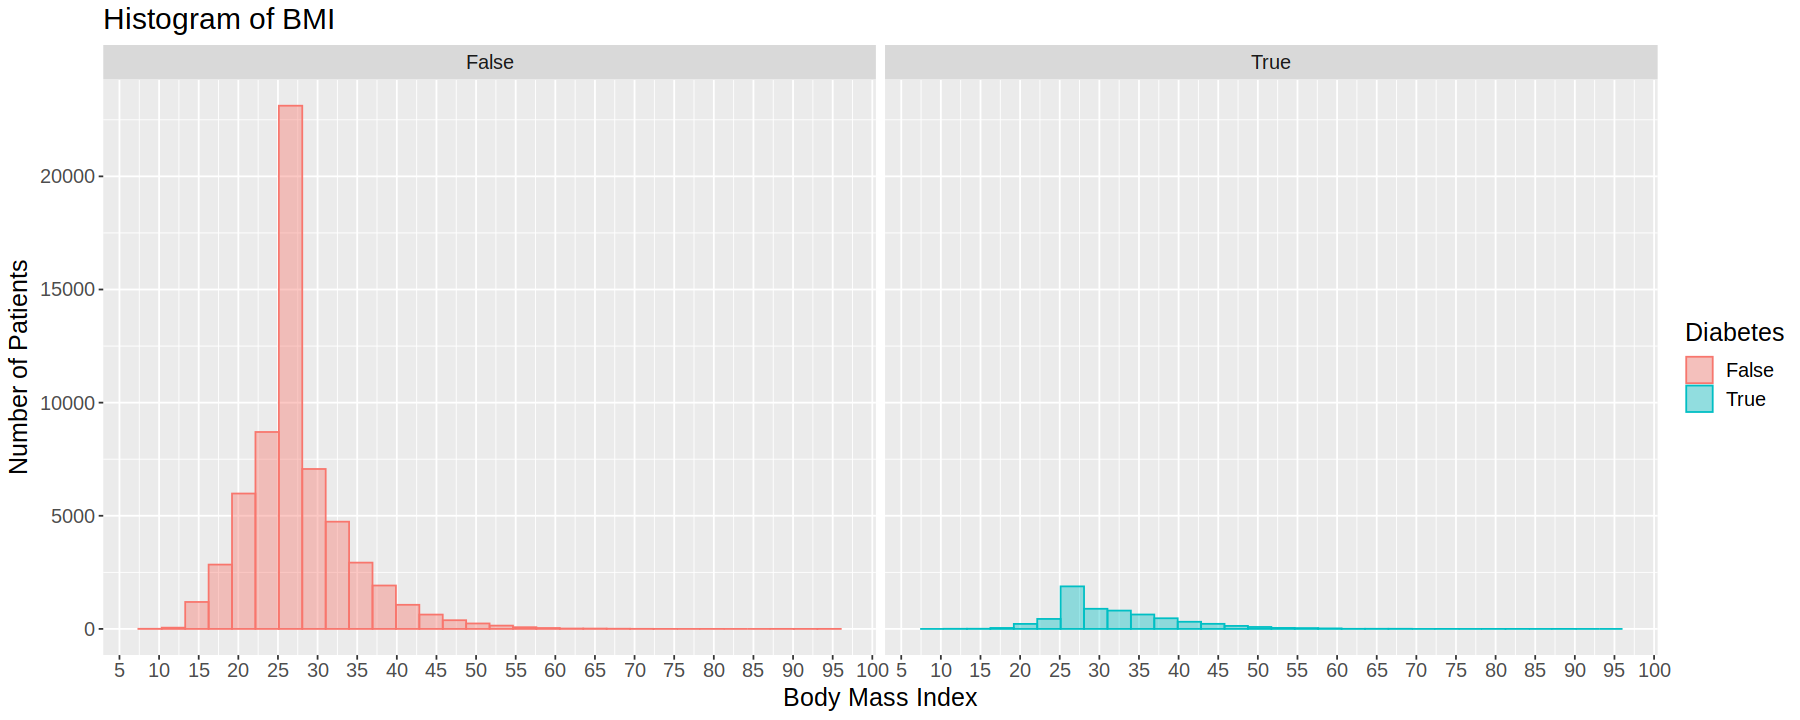

In [24]:
bmi_histogram <- diabetes_training |>
ggplot(aes(x = bmi, color = diabetes, fill = diabetes)) +
geom_histogram(alpha = 0.4) +
facet_grid(cols = vars(diabetes)) +
ggtitle("Histogram of BMI") +
labs(x = "Body Mass Index", y = "Number of Patients", color = "Diabetes", fill = "Diabetes") +
scale_x_continuous(breaks = seq(0, 100, by = 5)) +
theme(text = element_text(size = 15))
bmi_histogram

In [25]:
diabetes_training |>
filter(bmi > 55.0) |>
summarise(count = n(), maximum = max(bmi))

count maximum
1 231   95.69

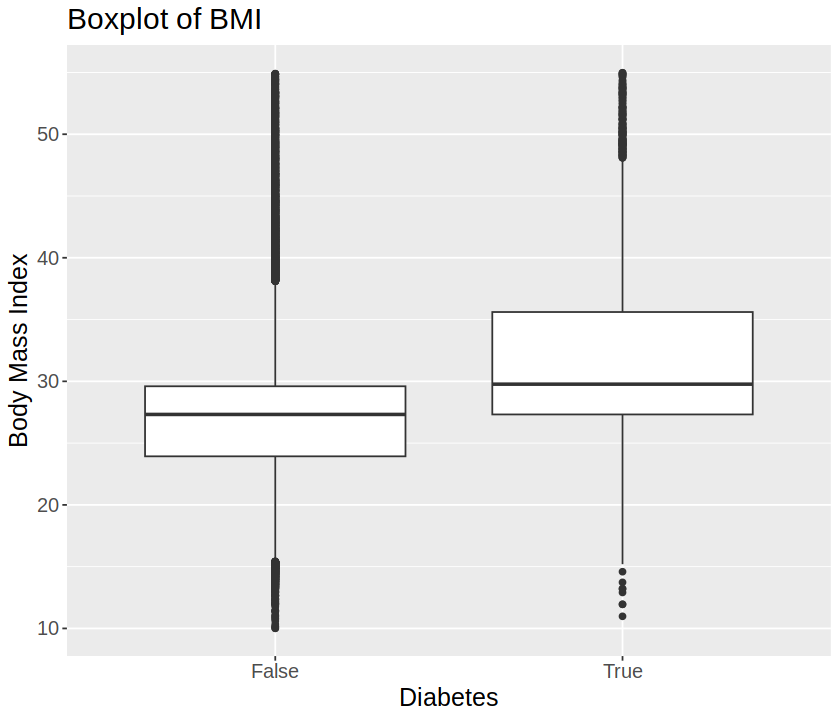

In [26]:
options(repr.plot.width = 7, repr.plot.height = 6)

bmi_boxplot <- diabetes_training |>
filter(bmi <= 55.0) |>
ggplot(aes(x = diabetes, y = bmi)) +
geom_boxplot() +
ggtitle("Boxplot of BMI") +
labs(x = "Diabetes", y = "Body Mass Index") +
theme(text = element_text(size = 15))
bmi_boxplot

Based on what is shown on the plots, there are some extremely high BMI values in this dataset (BMI > 55.0 with the maximum 96.0), which almost cannot happen for humans. After removing these abnormal data, we compare the distribution of bmi between diabetes classes. Based on the boxplot, there seems to be no significant difference in bmi between patients with and without diabetes. So we decided not to use bmi as a predictor variable in our final classification model.

### HbA1c Level

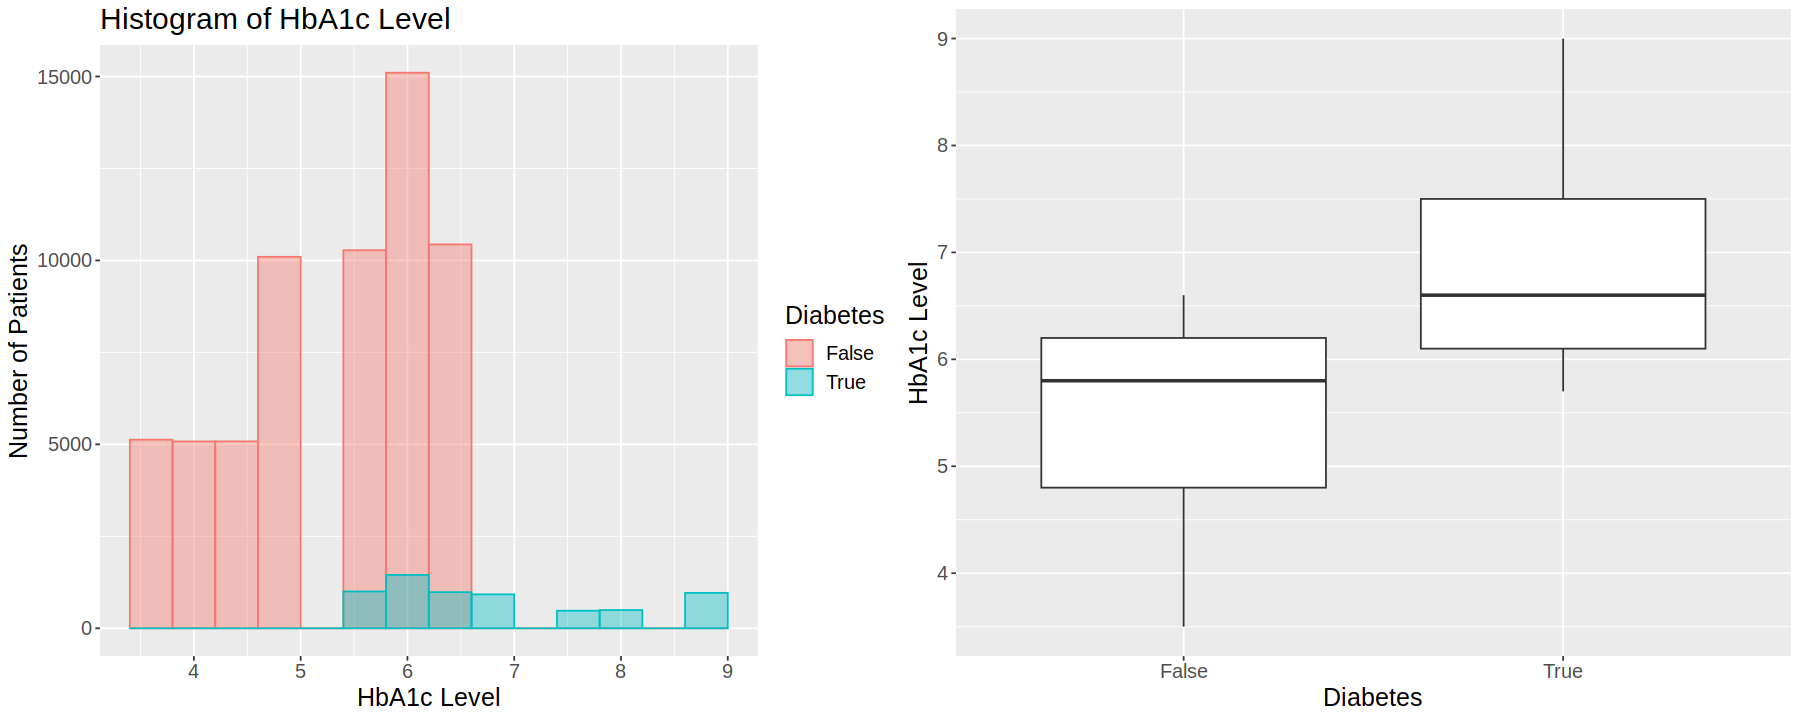

In [27]:
options(repr.plot.width = 15, repr.plot.height = 6)
hba1c_histogram <- diabetes_training |>
ggplot(aes(x = HbA1c_level, color = diabetes, fill = diabetes)) +
geom_histogram(alpha = 0.4, position = "identity", binwidth = 0.4) +
ggtitle("Histogram of HbA1c Level") +
labs(x = "HbA1c Level", y = "Number of Patients", color = "Diabetes", fill = "Diabetes") +
theme(text = element_text(size = 15))

hba1c_boxplot <- diabetes_training |>
ggplot(aes(x = diabetes, y = HbA1c_level)) +
geom_boxplot() +
labs(x = "Diabetes", y = "HbA1c Level") +
theme(text = element_text(size = 15))
grid.arrange(hba1c_histogram, hba1c_boxplot, ncol = 2)

From the plots above, there is a significance in average HbA1c levels between patients with and without diabetes, and patients with diabetes tend to have higher average HbA1c levels. This implies there may be some positive relationship between HbA1c level and diabetes.

### Blood Glucose Level

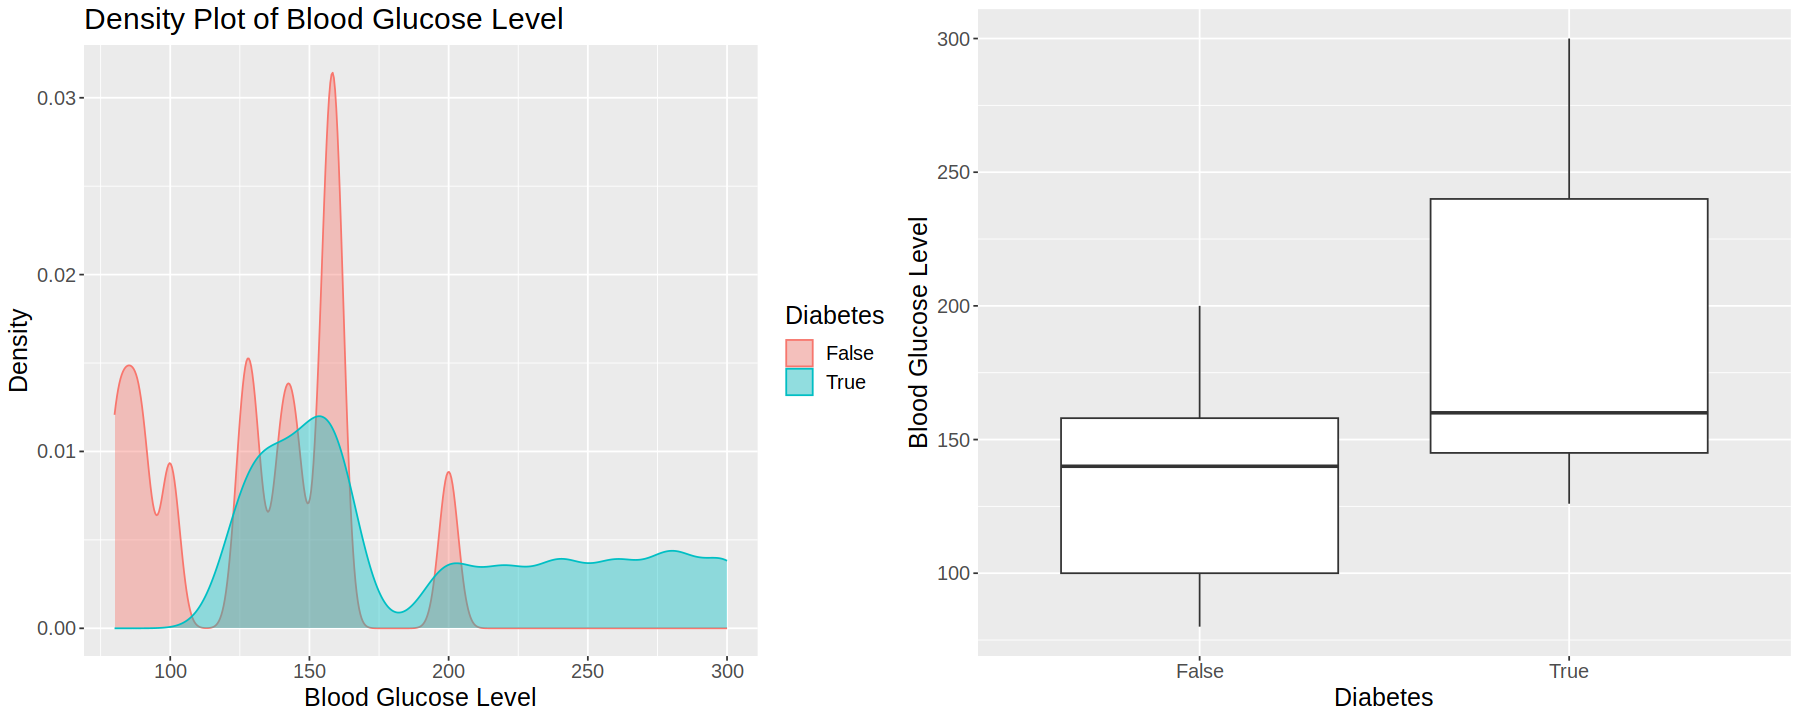

In [28]:
glucose_histogram <- diabetes_training |>
ggplot(aes(x = blood_glucose_level, color = diabetes, fill = diabetes)) +
geom_density(alpha = 0.4) +
ggtitle("Density Plot of Blood Glucose Level") +
labs(x = "Blood Glucose Level", y = "Density", color = "Diabetes", fill = "Diabetes") +
theme(text = element_text(size = 15))

glucose_boxplot <- diabetes_training |>
ggplot(aes(x = diabetes, y = blood_glucose_level)) +
geom_boxplot() +
labs(x = "Diabetes", y = "Blood Glucose Level") +
theme(text = element_text(size = 15))
grid.arrange(glucose_histogram, glucose_boxplot, ncol = 2)

### Gender

In [29]:
diabetes_training |>
group_by(gender, diabetes) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"))

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


gender diabetes count percentage
1 Female False    36587 54.21%    
2 Female True      3290 4.87%     
3 Male   False    24616 36.47%    
4 Male   True      3004 4.45%

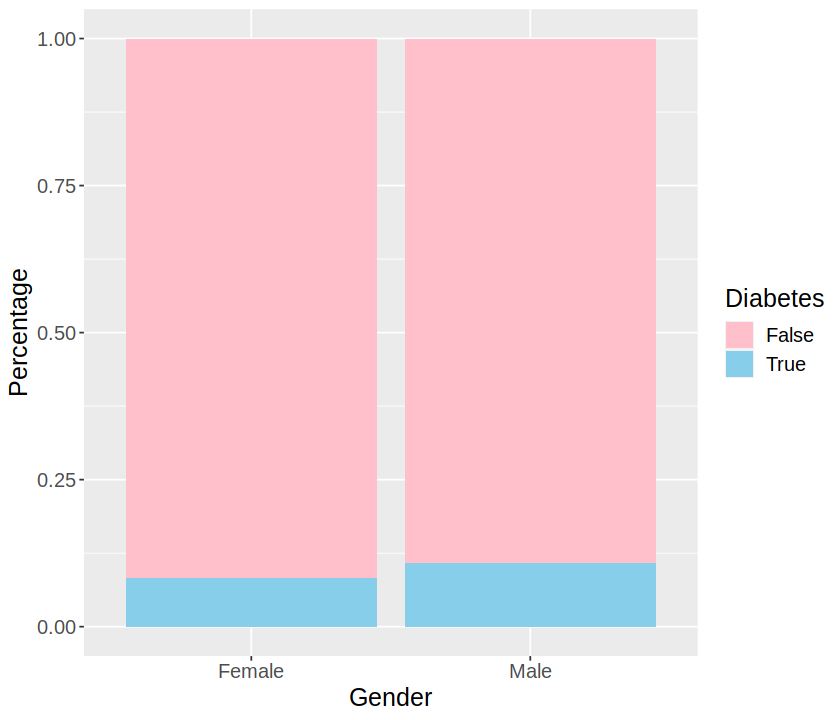

In [30]:
options(repr.plot.width = 7, repr.plot.height = 6)
diabetes_training |>
ggplot(aes(x = gender, fill = diabetes)) +
geom_bar(position = "fill") +
labs(x = "Gender", y = "Percentage", fill = "Diabetes") +
scale_fill_manual(values = c("pink", "skyblue")) +
theme(text = element_text(size = 15))

According to the plot above, there is no significant gender difference among diabetes patients. (Is there any study that could give some evidence for this??)

### Hypertension

In [31]:
diabetes_training |>
group_by(hypertension, diabetes) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"))

`summarise()` has grouped output by 'hypertension'. You can override using the
`.groups` argument.


hypertension diabetes count percentage
1 False        False    57168 84.7%     
2 False        True      4730 7.01%     
3 True         False     4035 5.98%     
4 True         True      1564 2.32%

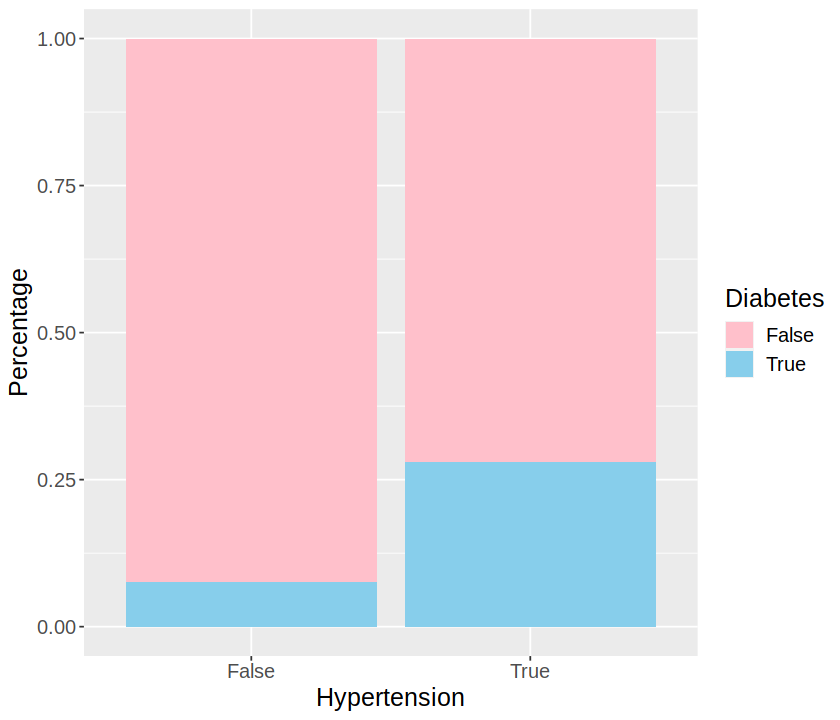

In [32]:
diabetes_training |>
ggplot(aes(x = hypertension, fill = diabetes)) +
geom_bar(position = "fill") +
labs(x = "Hypertension", y = "Percentage", fill = "Diabetes") +
scale_fill_manual(values = c("pink", "skyblue")) +
theme(text = element_text(size = 15))

The above plot shows significant difference in the proportions of diabetes patients. Patients with hypertension may have higher possibility to suffer from diabetes. This relationship seems to be strong and thus we would use hypertension as one of the predictors for our final classification model.

### Heart Disease

In [33]:
diabetes_training |>
group_by(heart_disease, diabetes) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"))

`summarise()` has grouped output by 'heart_disease'. You can override using the
`.groups` argument.


heart_disease diabetes count percentage
1 True          False     2000 2.96%     
2 True          True       940 1.39%     
3 False         False    59203 87.71%    
4 False         True      5354 7.93%

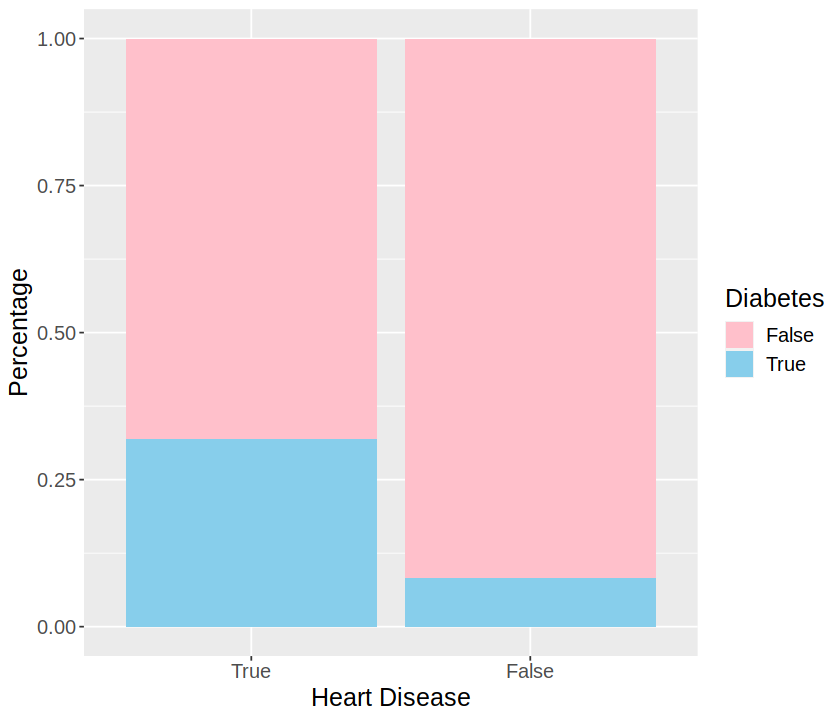

In [34]:
diabetes_training |>
ggplot(aes(x = heart_disease, fill = diabetes)) +
geom_bar(position = "fill") +
labs(x = "Heart Disease", y = "Percentage", fill = "Diabetes") +
scale_fill_manual(values = c("pink", "skyblue")) +
theme(text = element_text(size = 15))

The plot indicates a strong relationship between heart disease and diabetes. Patients with heart disease may be in higher risk in having a diabetes. Hence we would use heart disease as a predictor for our final classification model.

### Smoking History

In [35]:
diabetes_training |>
filter(diabetes == "False") |>
group_by(smoking_history) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"), diabetes = "False")

smoking_history count percentage diabetes
1 No Info         19482 31.83%     False   
2 current          6236 10.19%     False   
3 ever             2624 4.29%      False   
4 former           5773 9.43%      False   
5 never           22933 37.47%     False   
6 not current      4155 6.79%      False

In [36]:
diabetes_training |>
filter(diabetes == "True") |>
group_by(smoking_history) |>
summarise(count = n()) |>
ungroup() |>
mutate(percentage = paste0(round(100*count/sum(count), digit = 2), "%"), diabetes = "True")

smoking_history count percentage diabetes
1 No Info         1092  17.35%     True    
2 current          693  11.01%     True    
3 ever             363  5.77%      True    
4 former          1177  18.7%      True    
5 never           2468  39.21%     True    
6 not current      501  7.96%      True

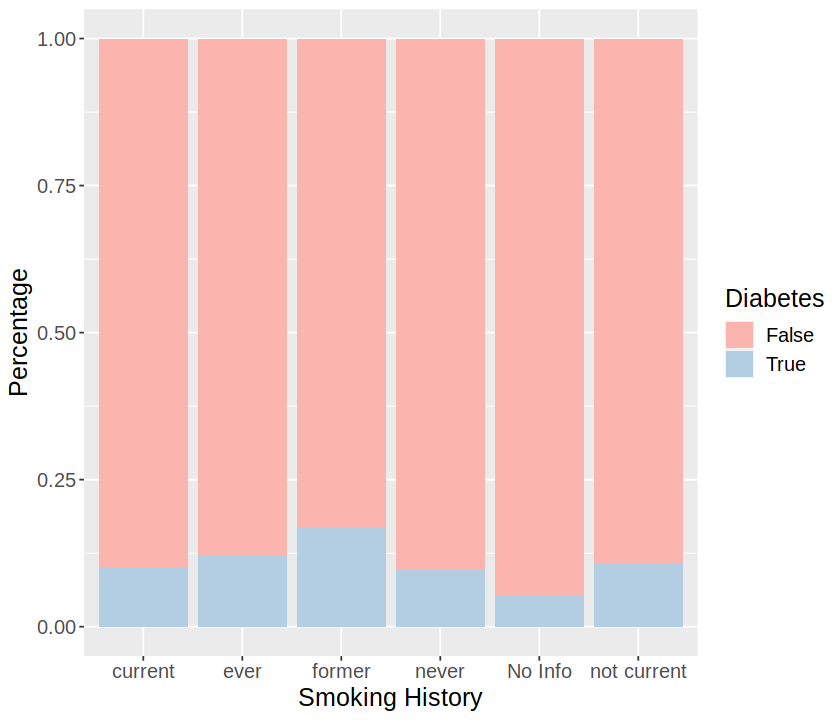

In [37]:
diabetes_training |>
ggplot(aes(x = smoking_history, fill = diabetes)) +
geom_bar(position = "fill") +
labs(x = "Smoking History", y = "Percentage", fill = "Diabetes") +
scale_fill_brewer(palette = "Pastel1") +
theme(text = element_text(size = 15))

## 3.3 Feature Selection
Based on all previous analysis, we decided to use age, hypertension, heart disease and HbA1c level as predictors in our classification model.

In [38]:
diabetes_training <- diabetes_training |>
select(-c(bmi, gender, smoking_history, blood_glucose_level))
diabetes_testing <- diabetes_testing |>
select(-c(bmi, gender, smoking_history, blood_glucose_level))
glimpse(diabetes_training)
glimpse(diabetes_testing)

Rows: 67,497
Columns: 5
$ age           <dbl> 80, 54, 28, 20, 44, 32, 53, 67, 78, 15, 42, 42, 40, 69, …
$ hypertension  <fct> False, False, False, False, False, False, False, False, …
$ heart_disease <fct> True, False, False, False, False, False, False, False, F…
$ HbA1c_level   <dbl> 6.6, 6.6, 5.7, 6.6, 6.5, 5.0, 6.1, 5.8, 6.6, 6.1, 5.7, 5…
$ diabetes      <fct> False, False, False, False, True, False, False, False, F…
Rows: 22,500
Columns: 5
$ age           <dbl> 36, 76, 79, 42, 54, 78, 76, 37, 43, 50, 41, 15, 26, 77, …
$ hypertension  <fct> False, True, False, False, False, False, False, False, F…
$ heart_disease <fct> False, True, False, False, False, False, False, False, F…
$ HbA1c_level   <dbl> 5.0, 4.8, 5.7, 4.8, 6.0, 5.0, 5.0, 3.5, 6.1, 4.0, 6.2, 4…
$ diabetes      <fct> False, False, False, False, False, False, False, False, …


### 3.3.1 Correlation Checking
Since they are all numeric, we can check the correlations between these variables.

In [39]:
diabetes_predictors <- diabetes_training |>
select(-diabetes) |>
mutate(hypertension = as.numeric(as.logical(hypertension)), heart_disease = as.numeric(as.logical(heart_disease)))

age       hypertension heart_disease HbA1c_level
age           1.0000000 0.25382361   0.2413687     0.10576121 
hypertension  0.2538236 1.00000000   0.1184610     0.08200835 
heart_disease 0.2413687 0.11846102   1.0000000     0.06615730 
HbA1c_level   0.1057612 0.08200835   0.0661573     1.00000000

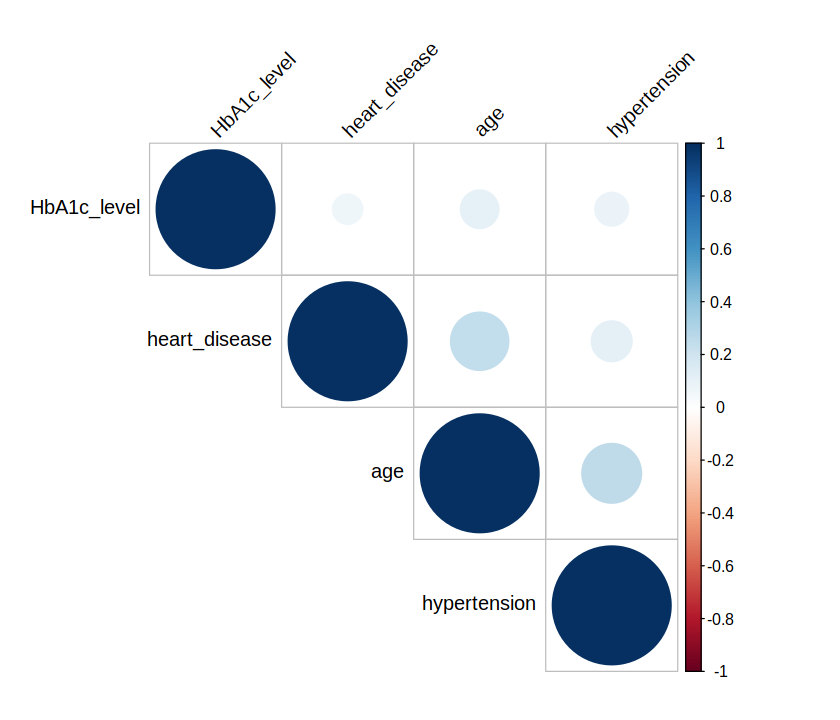

In [40]:
cor(diabetes_predictors)
corrplot(cor(diabetes_predictors), type = "upper", order = "hclust", tl.col = "black", tl.srt = 45)

The stronger the color and the bigger the size, the higher the correlation. The result is similar to the one we got earlier: all predictor variables have low level of correlations.